In [1]:
from collections import Counter

import numpy as np
from sklearn.base import is_regressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble.forest import BaseForest
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.tree.tree import BaseDecisionTree
from sklearn.utils import check_random_state
from sklearn.utils import check_X_y
#from sklearn.utils import shuffle

from sklearn import neighbors, tree, svm
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

import math
import random
import logging
import numbers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
class SMOTE(object):
    """Implementation of Synthetic Minority Over-Sampling Technique (SMOTE).
    SMOTE performs oversampling of the minority class by picking target 
    minority class samples and their nearest minority class neighbors and 
    generating new samples that linearly combine features of each target 
    sample with features of its selected minority class neighbors [1].
    
    Parameters
    ----------
    k_neighbors : int, optional (default=5)
        Number of nearest neighbors.
    random_state : int or None, optional (default=None)
        If int, random_state is the seed used by the random number generator.
        If None, the random number generator is the RandomState instance used
        by np.random.
    References
    ----------
    .. [1] N. V. Chawla, K. W. Bowyer, L. O. Hall, and P. Kegelmeyer. "SMOTE:
           Synthetic Minority Over-Sampling Technique." Journal of Artificial
           Intelligence Research (JAIR), 2002.
    """
    
    def __init__(self, k_neighbors=5, random_state=None):
        self.k = k_neighbors
        self.random_state = random_state
        
    def fit(self, X):
        """Train model based on input data.
        Parameters
        ----------
        X : array-like, shape = [n_minority_samples, n_features]
            Holds the minority samples.
        """
        self.X = X
        self.n_minority_samples, self.n_features = self.X.shape

        # Learn nearest neighbors.
        self.neigh = NearestNeighbors(n_neighbors=self.k + 1)
        self.neigh.fit(self.X)

        return self
    
    def sample(self, n_samples):
        """Generate samples.
        
        Parameters
        ----------
        n_samples : int
            Number of new synthetic samples.
            
        Returns
        -------
        S : array, shape = [n_samples, n_features]
            Returns synthetic samples.
        """
        np.random.seed(seed=self.random_state)
        
        S = np.zeros(shape=(n_samples, self.n_features))
        
        #Calculate synthetic samples.
        for i in range(n_samples):
            j = np.random.randint(0, self.X.shape[0])
            
            # Find the k NN for sample j.
            # Exclude the sample itself.
            nn = self.neigh.kneighbors(self.X[j].reshape(1, -1),
                                       return_distance=False)[:, 1:]
            nn_index = np.random.choice(nn[0])

            diff = self.X[nn_index] - self.X[j]
            gap = np.random.random()

            S[i, :] = self.X[j, :] + gap * diff[:]
        
        return S
    
    

In [3]:
class SMOTEBoost(AdaBoostClassifier):
    """Implementation of SMOTEBoost.
    SMOTEBoost introduces data sampling into the AdaBoost algorithm by
    oversampling the minority class using SMOTE on each boosting iteration [1].
    This implementation inherits methods from the scikit-learn 
    AdaBoostClassifier class, only modifying the `fit` method.
    Parameters
    ----------
    n_samples : int, optional (default=100)
        Number of new synthetic samples per boosting step.
    k_neighbors : int, optional (default=5)
        Number of nearest neighbors.
    base_estimator : object, optional (default=DecisionTreeClassifier)
        The base estimator from which the boosted ensemble is built.
        Support for sample weighting is required, as well as proper `classes_`
        and `n_classes_` attributes.
    n_estimators : int, optional (default=50)
        The maximum number of estimators at which boosting is terminated.
        In case of perfect fit, the learning procedure is stopped early.
    learning_rate : float, optional (default=1.)
        Learning rate shrinks the contribution of each classifier by
        ``learning_rate``. There is a trade-off between ``learning_rate`` and
        ``n_estimators``.
    algorithm : {'SAMME', 'SAMME.R'}, optional (default='SAMME.R')
        If 'SAMME.R' then use the SAMME.R real boosting algorithm.
        ``base_estimator`` must support calculation of class probabilities.
        If 'SAMME' then use the SAMME discrete boosting algorithm.
        The SAMME.R algorithm typically converges faster than SAMME,
        achieving a lower test error with fewer boosting iterations.
    random_state : int or None, optional (default=None)
        If int, random_state is the seed used by the random number generator.
        If None, the random number generator is the RandomState instance used
        by np.random.
    References
    ----------
    .. [1] N. V. Chawla, A. Lazarevic, L. O. Hall, and K. W. Bowyer.
           "SMOTEBoost: Improving Prediction of the Minority Class in
           Boosting." European Conference on Principles of Data Mining and
           Knowledge Discovery (PKDD), 2003.
    """

    def __init__(self,
                 n_samples=100,
                 k_neighbors=5,
                 base_estimator=None,
                 n_estimators=50,
                 learning_rate=1.,
                 algorithm='SAMME.R',
                 random_state=None):

        self.n_samples = n_samples
        self.algorithm = algorithm
        self.smote = SMOTE(k_neighbors=k_neighbors,
                           random_state=random_state)

        super(SMOTEBoost, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state)

    def fit(self, X, y, sample_weight=None, minority_target=None):
        """Build a boosted classifier/regressor from the training set (X, y),
        performing SMOTE during each boosting step.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR. The dtype is
            forced to DTYPE from tree._tree if the base classifier of this
            ensemble weighted boosting classifier is a tree or forest.
        y : array-like of shape = [n_samples]
            The target values (class labels in classification, real numbers in
            regression).
        sample_weight : array-like of shape = [n_samples], optional
            Sample weights. If None, the sample weights are initialized to
            1 / n_samples.
        minority_target : int
            Minority class label.
        Returns
        -------
        self : object
            Returns self.
        Notes
        -----
        Based on the scikit-learn v0.18 AdaBoostClassifier and
        BaseWeightBoosting `fit` methods.
        """
        # Check that algorithm is supported.
        if self.algorithm not in ('SAMME', 'SAMME.R'):
            raise ValueError("algorithm %s is not supported" % self.algorithm)

        # Check parameters.
        if self.learning_rate <= 0:
            raise ValueError("learning_rate must be greater than zero")

        if (self.base_estimator is None or
                isinstance(self.base_estimator, (BaseDecisionTree,
                                                 BaseForest))):
            DTYPE = np.float64  # from fast_dict.pxd
            dtype = DTYPE
            accept_sparse = 'csc'
        else:
            dtype = None
            accept_sparse = ['csr', 'csc']

        X, y = check_X_y(X, y, accept_sparse=accept_sparse, dtype=dtype,
                         y_numeric=is_regressor(self))

        if sample_weight is None:
            # Initialize weights to 1 / n_samples.
            sample_weight = np.empty(X.shape[0], dtype=np.float64)
            sample_weight[:] = 1. / X.shape[0]
        else:
            sample_weight = check_array(sample_weight, ensure_2d=False)
            # Normalize existing weights.
            sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

            # Check that the sample weights sum is positive.
            if sample_weight.sum() <= 0:
                raise ValueError(
                    "Attempting to fit with a non-positive "
                    "weighted number of samples.")

        if minority_target is None:
            # Determine the minority class label.
            stats_c_ = Counter(y)
            maj_c_ = max(stats_c_, key=stats_c_.get)
            min_c_ = min(stats_c_, key=stats_c_.get)
            self.minority_target = min_c_
        else:
            self.minority_target = minority_target

        # Check parameters.
        self._validate_estimator()

        # Clear any previous fit results.
        self.estimators_ = []
        self.estimator_weights_ = np.zeros(self.n_estimators, dtype=np.float64)
        self.estimator_errors_ = np.ones(self.n_estimators, dtype=np.float64)

        random_state = check_random_state(self.random_state)

        for iboost in range(self.n_estimators):
            X_min = X[np.where(y == self.minority_target)]

            # SMOTE step.
            if len(X_min) >= self.smote.k:
                self.smote.fit(X_min)
                X_syn = self.smote.sample(self.n_samples)
                y_syn = np.full(X_syn.shape[0], fill_value=self.minority_target,
                                dtype=np.int64)

                # Normalize synthetic sample weights based on current training set.
                sample_weight_syn = np.empty(X_syn.shape[0], dtype=np.float64)
                sample_weight_syn[:] = 1. / X.shape[0]

                # Combine the original and synthetic samples.
                X = np.vstack((X, X_syn))
                y = np.append(y, y_syn)

                # Combine the weights.
                sample_weight = \
                    np.append(sample_weight, sample_weight_syn).reshape(-1, 1)
                sample_weight = \
                    np.squeeze(normalize(sample_weight, axis=0, norm='l1'))

                # X, y, sample_weight = shuffle(X, y, sample_weight,
                #                              random_state=random_state)

            # Boosting step.
            sample_weight, estimator_weight, estimator_error = self._boost(
                iboost,
                X, y,
                sample_weight,
                random_state)

            # Early termination.
            if sample_weight is None:
                break

            self.estimator_weights_[iboost] = estimator_weight
            self.estimator_errors_[iboost] = estimator_error

            # Stop if error is zero.
            if estimator_error == 0:
                break

            sample_weight_sum = np.sum(sample_weight)

            # Stop if the sum of sample weights has become non-positive.
            if sample_weight_sum <= 0:
                break

            if iboost < self.n_estimators - 1:
                # Normalize.
                sample_weight /= sample_weight_sum

        return self

In [26]:
logger = logging.getLogger('pycobra.classifiercobra')


class ClassifierCobra(BaseEstimator):
    """
    Classification algorithm as introduced by
    Mojirsheibani [1999] Combining Classifiers via Discretization,
    Journal of the American Statistical Association.
    Parameters
    ----------
    random_state: integer or a numpy.random.RandomState object.
        Set the state of the random number generator to pass on to shuffle and loading machines, to ensure
        reproducibility of your experiments, for example.
    Attributes
    ----------
    machines: A dictionary which maps machine names to the machine objects.
            The machine object must have a predict method for it to be used during aggregation.
    machine_predictions: A dictionary which maps machine name to it's predictions over X_l
            This value is used to determine which points from y_l are used to aggregate.
    """
    def __init__(self, random_state=None, machine_list='basic'):
        self.random_state = random_state
        self.machine_list = machine_list

    def fit(self, X, y, default=True, X_k=None, X_l=None, y_k=None, y_l=None):
        """
        Parameters
        ----------
        X: array-like, [n_samples, n_features]
            Training data which will be used to create ClassifierCobra.
        y: array-like [n_samples]
            Training labels for classification.
        default: bool, optional
            If set as true then sets up COBRA with default machines and splitting.
        X_k : shape = [n_samples, n_features]
            Training data which is used to train the machines loaded into COBRA.
        y_k : array-like, shape = [n_samples]
            Target values used to train the machines loaded into COBRA.
        X_l : shape = [n_samples, n_features]
            Training data which is used during the aggregation of COBRA.
        y_l : array-like, shape = [n_samples]
            Target values which are actually used in the aggregation of COBRA.
        """

        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.X_k_ = X_k
        self.X_l_ = X_l
        self.y_k_ = y_k
        self.y_l_ = y_l
        self.estimators_ = {}

        # try block to pass scikit-learn estimator check.
        try:
            # set-up COBRA with default machines
            if default:
                self.split_data()
                self.load_default(machine_list=self.machine_list)
                self.load_machine_predictions()
        except ValueError:
            return self

        return self


    def pred(self, X, M, info=False):
        """
        Performs the CLassififerCobra aggregation scheme, used in predict method.
        Parameters
        ----------
        X: array-like, [n_features]
        M: int, optional
            M refers to the number of machines the prediction must be close to to be considered during aggregation.
        info: boolean, optional
            If info is true the list of points selected in the aggregation is returned.
        Returns
        -------
        result: prediction
        """

        # dictionary mapping machine to points selected
        select = {}
        for machine in self.estimators_:
            # machine prediction
            label = self.estimators_[machine].predict(X)
            select[machine] = set()
            # iterating from l to n
            # replace with numpy iteration
            for count in range(0, len(self.X_l_)):
                if self.machine_predictions_[machine][count] == label:
                    select[machine].add(count)

        points = []
        # count is the indice number.
        for count in range(0, len(self.X_l_)):
            # row check is number of machines which picked up a particular point
            row_check = 0
            for machine in select:
                if count in select[machine]:
                    row_check += 1
            if row_check == M:
                points.append(count)

        # if no points are selected, return 0
        if len(points) == 0:
            if info:
                logger.info("No points were selected, prediction is 0")
                return (0, 0)
            logger.info("No points were selected, prediction is 0")
            return 0

        # aggregate
        classes = {}
        for label in np.unique(self.y_l_):
            classes[label] = 0

        for point in points:
            classes[self.y_l_[point]] += 1

        result = int(max(classes, key=classes.get))
        if info:
            return result, points
        return result


    def predict(self, X, M=None, info=False):
        """
        Performs the ClassifierCobra aggregation scheme, calls pred.
        ClassifierCobra performs a majority vote among all points which are retained by the COBRA procedure.
        Parameters
        ----------
        X: array-like, [n_features]
        M: int, optional
            M refers to the number of machines the prediction must be close to to be considered during aggregation.
        info: boolean, optional
            If info is true the list of points selected in the aggregation is returned.
        Returns
        -------
        result: prediction
        """
        X = check_array(X)

        if M is None:
            M = len(self.estimators_)
        if X.ndim == 1:
            return self.pred(X.reshape(1, -1), M=M)

        result = np.zeros(len(X))
        avg_points = 0
        index = 0
        for vector in X:
            if info:
                result[index], points = self.pred(vector.reshape(1, -1), M=M, info=info)
                avg_points += len(points)
            else:
                result[index] = self.pred(vector.reshape(1, -1), M=M)
            index += 1
        
        if info:
            avg_points = avg_points / len(X_array)
            return result, avg_points
        
        return result


    def predict_proba(self, X, kernel=None, metric=None, bandwidth=1, **kwargs): 
        """
        Performs the ClassifierCobra aggregation scheme and calculates probability of a point being in a particular class.
        ClassifierCobra performs a majority vote among all points which are retained by the COBRA procedure.
        
        NOTE: this method is to visualise boundaries.
        The current method is just the mean of the consituent machines, as the concept of that kind of predicted probability
        doesn't exist (yet) for classifier cobra.
        Parameters
        ----------
        X: array-like, [n_features]
        """

        probs = []
        for machine in self.estimators_:
            try:
                probs.append(self.estimators_[machine].predict_proba(X))
            except AttributeError:
                continue
        prob = np.mean(probs, axis=0)
        return prob


    def split_data(self, k=None, l=None, shuffle_data=True):
        """
        Split the data into different parts for training machines and for aggregation.
        Parameters
        ----------
        k : int, optional
            k is the number of points used to train the machines.
            Those are the first k points of the data provided.
        l: int, optional
            l is the number of points used to form the ClassifierCobra aggregate.
        shuffle: bool, optional
            Boolean value to decide to shuffle the data before splitting.
        Returns
        -------
        self : returns an instance of self.
        """

        if shuffle_data:
            self.X_, self.y_ = shuffle(self.X_, self.y_, random_state=self.random_state)

        if k is None and l is None:
            k = int(len(self.X_) / 2)
            l = int(len(self.X_))

        if k is not None and l is None:
            l = len(self.X_) - k

        if l is not None and k is None:
            k = len(self.X_) - l

        self.X_k_ = self.X_[:k]
        self.X_l_ = self.X_[k:l]
        self.y_k_ = self.y_[:k]
        self.y_l_ = self.y_[k:l]

        return self


    def load_default(self, machine_list='basic'):
        """
        Loads 4 different scikit-learn regressors by default. The advanced list adds more machines. 
        As of current release SGD algorithm is not included in the advanced list.
        Parameters
        ----------
        machine_list: optional, list of strings
            List of default machine names to be loaded.
        Returns
        -------
        self : returns an instance of self.
        """
        if machine_list == 'cobra':
            machine_list = ['cobra', 'cobra', 'cobra', 'cobra', 'cobra', 'cobra']

        for machine in machine_list:
            try:
                if machine == 'svm':
                    self.estimators_['svm'] = svm.SVC().fit(self.X_k_, self.y_k_)
                if machine == 'knn':
                    self.estimators_['knn'] = neighbors.KNeighborsClassifier().fit(self.X_k_, self.y_k_)
                if machine == 'tree':
                    self.estimators_['tree'] = tree.DecisionTreeClassifier().fit(self.X_k_, self.y_k_)
                if machine == 'logreg':
                    self.estimators_['logreg'] = LogisticRegression(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'naive_bayes':
                    self.estimators_['naive_bayes'] = GaussianNB().fit(self.X_k_, self.y_k_)
                if machine == 'lda':
                    self.estimators_['lda'] = LinearDiscriminantAnalysis().fit(self.X_k_, self.y_k_)
                if machine == 'neural_network':
                    self.estimators_['neural_network'] = MLPClassifier(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'cobra':
                    self.estimators_['cobra'] = SMOTEBoost().fit(self.X_k_, self.y_k_)
            except ValueError:
                continue

        return self


    def load_machine(self, machine_name, machine):
        """
        Adds a machine to be used during the aggregation strategy.
        The machine object must have been trained using X_k and y_k, and must have a 'predict()' method.
        After the machine is loaded, for it to be used during aggregation, load_machine_predictions must be run.
        Parameters
        ----------
        machine_name : string
            Name of the machine you are loading
        machine: machine/regressor object
            The regressor machine object which is mapped to the machine_name
        Returns
        -------
        self : returns an instance of self.
        """

        self.estimators_[machine_name] = machine

        return self


    def load_machine_predictions(self, predictions=None):
        """
        Stores the trained machines' predicitons on D_l in a dictionary, to be used for predictions.
        Should be run after all the machines to be used for aggregation is loaded.
        Parameters
        ----------
        predictions: dictionary, optional
            A pre-existing machine:predictions dictionary can also be loaded.
        Returns
        -------
        self : returns an instance of self.
        """
        self.machine_predictions_ = {}
        if predictions is None:
            for machine in self.estimators_:
                self.machine_predictions_[machine] = self.estimators_[machine].predict(self.X_l_)

        return self


    def load_machine_proba_predictions(self, predictions=None):
        """
        Stores the trained machines' predicitons on D_l in a dictionary, to be used for predictions.
        Should be run after all the machines to be used for aggregation is loaded.
        Parameters
        ----------
        predictions: dictionary, optional
            A pre-existing machine:predictions dictionary can also be loaded.
        Returns
        -------
        self : returns an instance of self.
        """
        self.machine_proba_predictions_ = {}
        if predictions is None:
            for machine in self.estimators_:
                try:
                    self.machine_proba_predictions_[machine] = self.estimators_[machine].predict_proba(self.X_l_)
                except AttributeError:
                    self.machine_proba_predictions_[machine] = self.estimators_[machine].decision_function(self.X_l_)
        return self

In [5]:
# from pycobra.classifiercobra import ClassifierCobra
%pip install pycobra

Note: you may need to restart the kernel to use updated packages.


In [6]:
# from pycobra.classifiercobra import ClassifierCobra

In [7]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(ClassifierCobra)

In [8]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
bc = datasets.load_breast_cancer()
X = bc.data[:-20]
y = bc.target[:-20]
X_test = bc.data[-20:]
y_test = bc.target[-20:]

In [9]:
cc = ClassifierCobra(machine_list='basic')

In [10]:
from sklearn.metrics import f1_score
cc.fit(X, y)
f1_score(y_test, cc.predict(X_test), average='weighted')

1.0

In [27]:
df = pd.read_csv('Datasets/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [29]:
df['Class'].unique()

array([0, 1], dtype=int64)

In [30]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [31]:
df.isnull().sum().max()

0

In [32]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


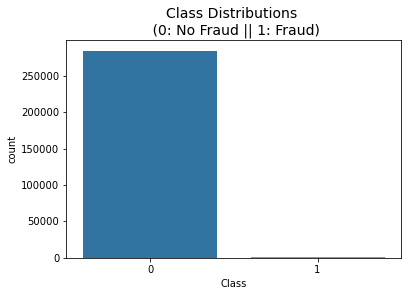

In [33]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

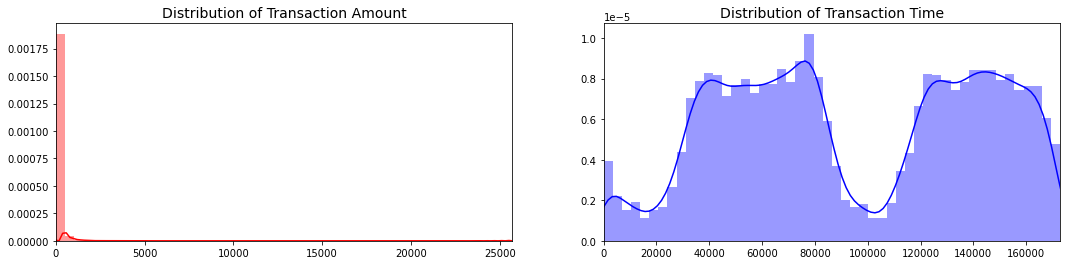

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [35]:
from sklearn.preprocessing import RobustScaler

# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [36]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [37]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df.drop('Class', axis=1),
                                                 df['Class'],
                                                 test_size=0.2,
                                                 random_state=1)

In [38]:
cc = ClassifierCobra(machine_list='cobra')

In [43]:
cc.fit(x_train, y_train)
print("Cobra SMOTE Boost f1 score: ", end="")
f1_score(y_test, cc.predict(x_test), average='weighted')

Cobra SMOTE Boost f1 score: 

KeyboardInterrupt: 

In [42]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)

print("AdaBoost f1 score: ", end="")
f1_score(y_test, clf.predict(x_test), average='weighted')

AdaBoost f1 score: 

0.9991727875624508